# importowanie potrzebnych bibliotek

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random
from torch.optim import Adam

# Wczytanie danych


Podzielenie danych na zbiory testowe i treningowe. Dane które zostały pobrane przy pomocy tej metody trzeba było przerobić, ponieważ brakuje wymiaru kanału, który jest niezbędny dla sieci CNN.

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


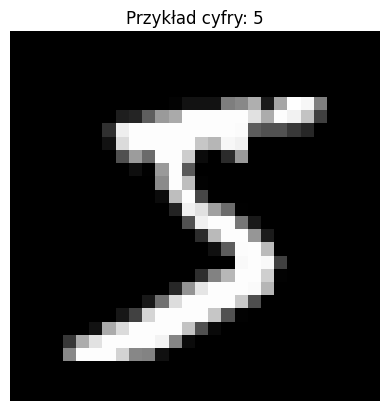

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.from_numpy(y_train)

x_train_tensor = torch.from_numpy(x_train).permute(0, 3, 1, 2).float()
y_train_tensor = torch.from_numpy(y_train).long()

x_test_tensor = torch.from_numpy(x_test).permute(0, 3, 1, 2).float()
y_test_tensor = torch.from_numpy(y_test).long()

print(x_train_tensor.shape)
print(y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

Sprawdzenie danych, jakie liczby zawierają się w tym datasecie oraz ile ich jest

In [ ]:
numbers = []
for i in y_train:
  if i not in numbers:
    numbers.append(i)
print(numbers)

[np.uint8(5), np.uint8(0), np.uint8(4), np.uint8(1), np.uint8(9), np.uint8(2), np.uint8(3), np.uint8(6), np.uint8(7), np.uint8(8)]


# CNN

Setup

In [ ]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Zdefiniowanie sieci CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(1,32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.25)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model = CNN().to(device)

In [ ]:
print(x_train_tensor.shape)
print(y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


Pętla uczenia, 5 epok, learning rate = 0.001, optymalizator Adam oraz kryterium entropii krzyżowej, które mówi nam jak bardzo przewidywania sieci różnią się od tego co ma faktycznie być.

Finalnie wytrenowana sieć pokazuje, że na zbiorze treningowym ma 93% accuracy oraz loss 0.2428 natomiast na zbiorze testowym wynik jest już nieco lepszy, mianowicie dokładność jest na poziomie 94,5% i loss wynosi 0.1811.

In [ ]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(X, y, train: bool):
  epoch_loss, correct, total = 0.0, 0, 0
  if train:
    model.train()
  else:
    model.eval()

  for i in range(0, len(X)):
    xb = X[i]
    yb = y[i]
    xb = xb.unsqueeze(0)
    yb = yb.unsqueeze(0)
    xb, yb = xb.float().to(device, non_blocking=True), yb.to(device, non_blocking=True)
    if train:
      optimizer.zero_grad()
    with torch.set_grad_enabled(train):
      logits = model(xb)
      loss = criterion(logits, yb)
      if train:
        loss.backward()
        optimizer.step()
    epoch_loss += loss.item() * xb.size(0)
    preds = logits.argmax(1)
    correct += (preds == yb).sum().item()
    total += yb.size(0)
  return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(x_train_tensor, y_train_tensor, train=True)
    va_loss, va_acc = run_epoch(x_test_tensor, y_test_tensor, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.2626 acc 0.9282 | val loss 0.2189 acc 0.9344
Ep 02/5 | train loss 0.2447 acc 0.9327 | val loss 0.1751 acc 0.9472
Ep 03/5 | train loss 0.2599 acc 0.9253 | val loss 0.1621 acc 0.9505
Ep 04/5 | train loss 0.2483 acc 0.9282 | val loss 0.1719 acc 0.9481
Ep 05/5 | train loss 0.2428 acc 0.9299 | val loss 0.1811 acc 0.9458
Czas treningu: 4191.6s


# Badanie - zwykła sieć vs CNN

Zdefiniowanie zestawów testowych oraz treningowych, standaryzacja tych zestawów oraz ograniczenie liczebności datasetu (5000 zbiór treningowy i 1000 zbiór testowy)

In [92]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train_tensor = torch.from_numpy(x_train).float() / 255.0
y_train_tensor = torch.from_numpy(y_train).long()

x_test_tensor = torch.from_numpy(x_test).float() / 255.0
y_test_tensor = torch.from_numpy(y_test).long()

batch_size = 64
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(x_test_tensor, y_test_tensor)

train_subset = Subset(train_dataset, range(5000))
test_subset  = Subset(test_dataset, range(1000))

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

Prosta sieć neuronowa

In [93]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(input_size=28*28, hidden_size=128, output_size=10).to(device)

Pętla uczenia 5 epok, learning rate = 0.001, optymalizator Adam oraz kryterium entropii krzyżowej.

Uczenie prostej sieci neuronowej, finalny wynik to 97% dokładności oraz 0.0693 loss dla zbioru treningowego. Natomiast gorzej wypada finalny test na zbiorze testowym, ponieważ dokładność spada do 90% a loss to już 0.5623.

In [95]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(test_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 1.0553 acc 0.7570 | val loss 0.5723 acc 0.8350
Ep 02/5 | train loss 0.3867 acc 0.8974 | val loss 0.4077 acc 0.8790
Ep 03/5 | train loss 0.2957 acc 0.9200 | val loss 0.3596 acc 0.8910
Ep 04/5 | train loss 0.2503 acc 0.9298 | val loss 0.3419 acc 0.8950
Ep 05/5 | train loss 0.2164 acc 0.9432 | val loss 0.3289 acc 0.8960
Czas treningu: 0.8s


Definiowanie zbioru testowego i treningowego dla sieci CNN

In [96]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train_cnn = x_train[..., np.newaxis]
x_test_cnn  = x_test[..., np.newaxis]

x_train_tensor_cnn = torch.from_numpy(x_train_cnn).permute(0, 3, 1, 2).float()
y_train_tensor_cnn = torch.from_numpy(y_train).long()

x_test_tensor_cnn = torch.from_numpy(x_test_cnn).permute(0, 3, 1, 2).float()
y_test_tensor_cnn = torch.from_numpy(y_test).long()

batch_size = 64
train_dataset_cnn = TensorDataset(x_train_tensor_cnn, y_train_tensor_cnn)
test_dataset_cnn  = TensorDataset(x_test_tensor_cnn, y_test_tensor_cnn)

train_subset_cnn = Subset(train_dataset_cnn, range(5000))
test_subset_cnn  = Subset(test_dataset_cnn, range(1000))

train_loader_cnn = DataLoader(train_subset_cnn, batch_size=batch_size, shuffle=True)
test_loader_cnn  = DataLoader(test_subset_cnn, batch_size=batch_size, shuffle=False)



In [105]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_cnn = SimpleCNN().to(device)

Pętla uczenia dla sieci CNN

Sieć CNN radzi sobie lepiej na zbiorze treningowym, ale wypada podobnie na zbiorze testowym co zwykła sieć.

In [107]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model_cnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model_cnn.train()
    else:
        model_cnn.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model_cnn(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader_cnn, train=True)
    va_loss, va_acc = run_epoch(test_loader_cnn, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 2.0828 acc 0.7050 | val loss 0.2295 acc 0.9360
Ep 02/5 | train loss 0.2359 acc 0.9308 | val loss 0.1694 acc 0.9390
Ep 03/5 | train loss 0.1683 acc 0.9448 | val loss 0.1105 acc 0.9620
Ep 04/5 | train loss 0.1291 acc 0.9570 | val loss 0.1150 acc 0.9610
Ep 05/5 | train loss 0.0962 acc 0.9678 | val loss 0.1119 acc 0.9630
Czas treningu: 21.8s


# Badanie - zmiana parametrów sieci CNN

Do badania efektywności sieci używam cross entropy loss oraz accuracy, które odpowiednio mówią nam jak bardzo sieć się myli względem tego co powinno być naprawdę oraz procent trafionych dobrze liczb na tle całego datasetu.

Zwiększenie szerokości oraz wysokości sieci

In [110]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(256 * 3 * 3, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_cnn2 = SimpleCNN().to(device)

In [111]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model_cnn2.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model_cnn2.train()
    else:
        model_cnn2.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model_cnn2(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader_cnn, train=True)
    va_loss, va_acc = run_epoch(test_loader_cnn, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 1.5800 acc 0.6500 | val loss 0.2269 acc 0.9310
Ep 02/5 | train loss 0.2243 acc 0.9332 | val loss 0.1275 acc 0.9570
Ep 03/5 | train loss 0.1489 acc 0.9546 | val loss 0.1362 acc 0.9640
Ep 04/5 | train loss 0.1190 acc 0.9608 | val loss 0.0694 acc 0.9770
Ep 05/5 | train loss 0.1168 acc 0.9644 | val loss 0.1200 acc 0.9600
Czas treningu: 89.5s


Widać, że statystyki treningu znacznie się poprawiły, tak samo jak statystyki z testowania tej sieci, które mówią, że loss znacznie się zmniejszył i zwiększyła się również dokładność. Sieć dobrze zgaduje liczby i jest pewna swoich decyzji. Wydłużył się znacznie czas treningu tej sieci.

Zmniejszenie wysokości i szerokości sieci

In [114]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(4 * 14 * 14, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_cnn3 = SimpleCNN().to(device)

In [115]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model_cnn3.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model_cnn3.train()
    else:
        model_cnn3.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model_cnn3(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader_cnn, train=True)
    va_loss, va_acc = run_epoch(test_loader_cnn, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 1.4052 acc 0.6698 | val loss 0.3949 acc 0.8760
Ep 02/5 | train loss 0.4094 acc 0.8714 | val loss 0.2718 acc 0.9120
Ep 03/5 | train loss 0.3010 acc 0.8990 | val loss 0.2227 acc 0.9280
Ep 04/5 | train loss 0.2348 acc 0.9236 | val loss 0.2357 acc 0.9290
Ep 05/5 | train loss 0.1882 acc 0.9400 | val loss 0.2137 acc 0.9380
Czas treningu: 3.2s


Zmniejszenie szerokości i wysokości sieci nie spowodowało znacznego pogorszenia sieci, lekko zwiększył się loss oraz zmniejszyła dokładność ale dalej sieć jest dobra.

**Badanie wpływu BatchNorm oraz wartości Dropout**

Dodanie BatchNorm

In [118]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_cnn4 = SimpleCNN().to(device)

In [120]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model_cnn4.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model_cnn4.train()
    else:
        model_cnn4.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model_cnn4(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader_cnn, train=True)
    va_loss, va_acc = run_epoch(test_loader_cnn, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.6960 acc 0.7874 | val loss 0.2277 acc 0.9430
Ep 02/5 | train loss 0.2042 acc 0.9434 | val loss 0.1486 acc 0.9530
Ep 03/5 | train loss 0.1396 acc 0.9590 | val loss 0.1127 acc 0.9630
Ep 04/5 | train loss 0.1001 acc 0.9700 | val loss 0.0953 acc 0.9710
Ep 05/5 | train loss 0.0946 acc 0.9726 | val loss 0.0765 acc 0.9770
Czas treningu: 30.0s


Dodanie BatchNorm poskutkowało tym, że statystyki samego treningu jak i testowania sieci polepszyły się znacznie, zmniejszając lossa i zwiększając dokładność.

Zmniejszenie, zwiększenie dropout

In [127]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.001)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_cnn5 = SimpleCNN().to(device)

In [128]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model_cnn5.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model_cnn5.train()
    else:
        model_cnn5.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model_cnn5(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader_cnn, train=True)
    va_loss, va_acc = run_epoch(test_loader_cnn, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 2.3013 acc 0.7408 | val loss 0.2406 acc 0.9220
Ep 02/5 | train loss 0.1595 acc 0.9514 | val loss 0.1540 acc 0.9430
Ep 03/5 | train loss 0.0839 acc 0.9730 | val loss 0.1450 acc 0.9370
Ep 04/5 | train loss 0.0574 acc 0.9820 | val loss 0.1158 acc 0.9560
Ep 05/5 | train loss 0.0418 acc 0.9858 | val loss 0.1017 acc 0.9630
Czas treningu: 21.6s


Zmniejszenie dropout poprawia działanie sieci, zmniejszając loss oraz dokładność

Zwiększenie Dropout

In [129]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.9)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_cnn6 = SimpleCNN().to(device)

In [130]:
EPOCHS = 5
lr = 1e-3
optimizer = Adam(model_cnn6.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model_cnn6.train()
    else:
        model_cnn6.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model_cnn6(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader_cnn, train=True)
    va_loss, va_acc = run_epoch(test_loader_cnn, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 7.9193 acc 0.1126 | val loss 2.2976 acc 0.1170
Ep 02/5 | train loss 2.2817 acc 0.1516 | val loss 2.2587 acc 0.2560
Ep 03/5 | train loss 2.2466 acc 0.1778 | val loss 2.2160 acc 0.3500
Ep 04/5 | train loss 2.2121 acc 0.2018 | val loss 2.1160 acc 0.4750
Ep 05/5 | train loss 2.1400 acc 0.2280 | val loss 1.9602 acc 0.5890
Czas treningu: 21.8s


Zwiększenie dropout sprawiło, że sieć jakby uczyła się wolniej, prawdopodobnie zwiększenie liczby epok poskutkowałoby tym, że finalnie sieć nauczyłaby się poprawnie klasyfikować liczby.

# Podsumowanie

Zwykła sieć neuronowa nieznacznie się różni skutecznością od CNN akurat dla tego problemu, podejrzewam, że przy bardziej złożonych klasyfikacjach CNN byłaby nieporównywalnie lepsza. Badanie zmian parametrów sieci CNN pokazało, że przy odpowiednim doborze parametrów można jeszcze bardziej zwiększyć skuteczność sieci a niewłaściwie dobrane parametry mogą tylko zaszkodzić.